# Exploratory Data Analysis (EDA)

## Loading the data

**Exploratory Data Analysis (EDA)** is performed on the full dataset *before* splitting into training and test sets. This allows us to understand the data's structure, distributions, and relationships, which informs decisions about preprocessing and feature engineering.

> ⚠️ **Data snooping warning**: While EDA is performed on the full dataset, it's crucial that any *decisions* derived from this analysis (such as choosing preprocessing strategies or creating new features) are only *fitted* on the training data after the split. The goal of EDA is to understand the data, not to optimize for specific values that might leak information from what will become the test set. For example, we can observe that `median_income` is highly correlated with the target here, but when we later perform stratified sampling or fit scalers, we must use only the training set.

In [ ]:
import pandas as pd
import numpy as np

housing = pd.read_csv("./data/housing.csv") # Load the dataset

## Geographic data visualization

Let's create a scatter plot of all districts to visualize the geographic data.

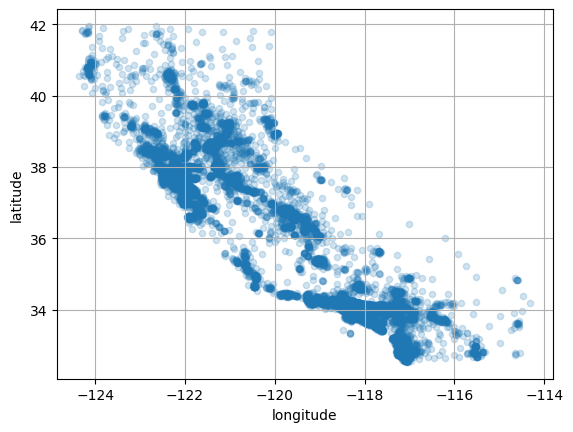

In [ ]:
import matplotlib.pyplot as plt

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2);

Visualization of each record on its geographic position (latitude and longitude), with a color scale representing the median house value and circle size representing the population.

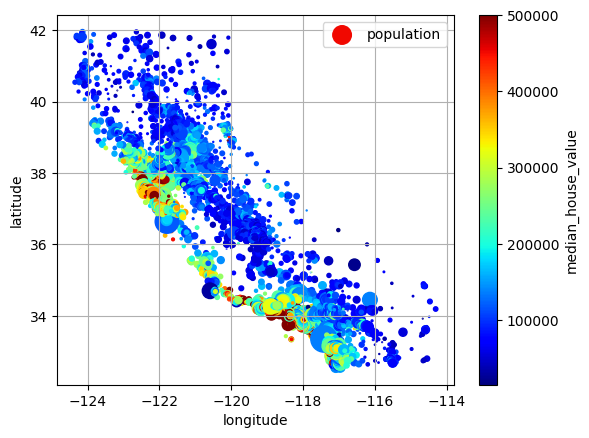

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, # circle radius represents district population
             label="population", # label for the legend
             c="median_house_value", # point color represents median house value
             cmap="jet", # use the "jet" color palette
             colorbar=True,
             legend=True);

Positioning the same on a map.

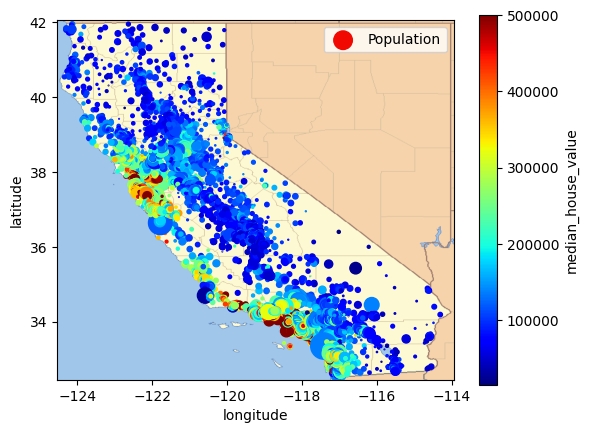

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude",
             s=housing["population"] / 100, # circle size proportional to population
             label="Population", 
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True)

california_img = plt.imread("./img/california.png")
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

plt.show()

Visualizing the 'ocean_proximity' values with colors geographically (will be useful when we preprocess this categorical variable).

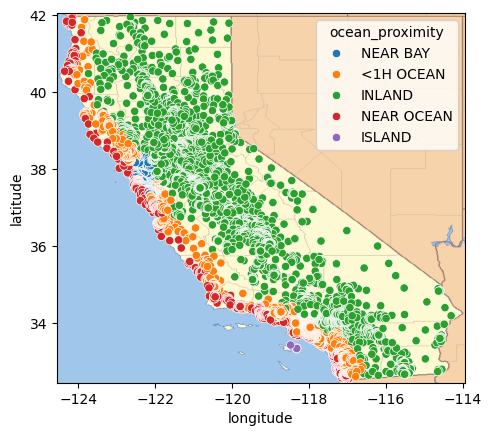

In [ ]:
import seaborn as sns
import PIL
import matplotlib.pyplot as plt

sns.scatterplot(x="longitude", y="latitude", hue="ocean_proximity", data=housing)
axis = -124.55, -113.95, 32.45, 42.05 # longitude and latitude limits of the image
plt.imshow(PIL.Image.open("./img/california.png", mode='r'), extent=axis)
plt.show()

## Looking for correlations

The `corr()` method of Pandas calculates the **Pearson correlation coefficient** (PCC) between each pair of attributes. This coefficient ranges from -1 to 1 indicating the degree of linear correlation between two variables. When it's close to 1, it means there's a strong positive correlation (variables tend to increase together). When the coefficient is close to -1, it means there's a strong negative correlation (one variable decreases when the other increases). Finally, coefficients close to 0 mean there's no linear correlation.
We use the argument `numeric_only=True` to calculate correlation only between numeric variables, ignoring the categorical variable 'ocean_proximity'.

In [ ]:
corr_matrix = housing.corr(numeric_only=True) 

Having this correlation matrix, let's see in an ordered way which variables correlate most with the **target variable**, 'median_house_value'. The `sort_values()` method of Pandas allows us to sort the values of a series; additionally, we can use the `key` parameter to pass a function that will be applied to each value before sorting. In this case, we want to sort by absolute value, since a strong negative correlation is just as interesting as a positive one.

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False, key=np.abs) # sort values by correlation with respect to absolute value

median_house_value    1.000000
median_income         0.688075
latitude             -0.144160
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
longitude            -0.045967
population           -0.024650
Name: median_house_value, dtype: float64

We observe that the variable that correlates most with 'median_house_value' is 'median_income', with a coefficient of 0.69. It's therefore the ***feature*** that most determines housing prices.

We can also see the correlations with a scatter plot of the variables most correlated with 'median_house_value', using the `scatter_matrix` function from Pandas. On the diagonal we see that it places their histograms (as seen at the beginning) by default, since comparing a variable with itself would only give a straight line without useful information.

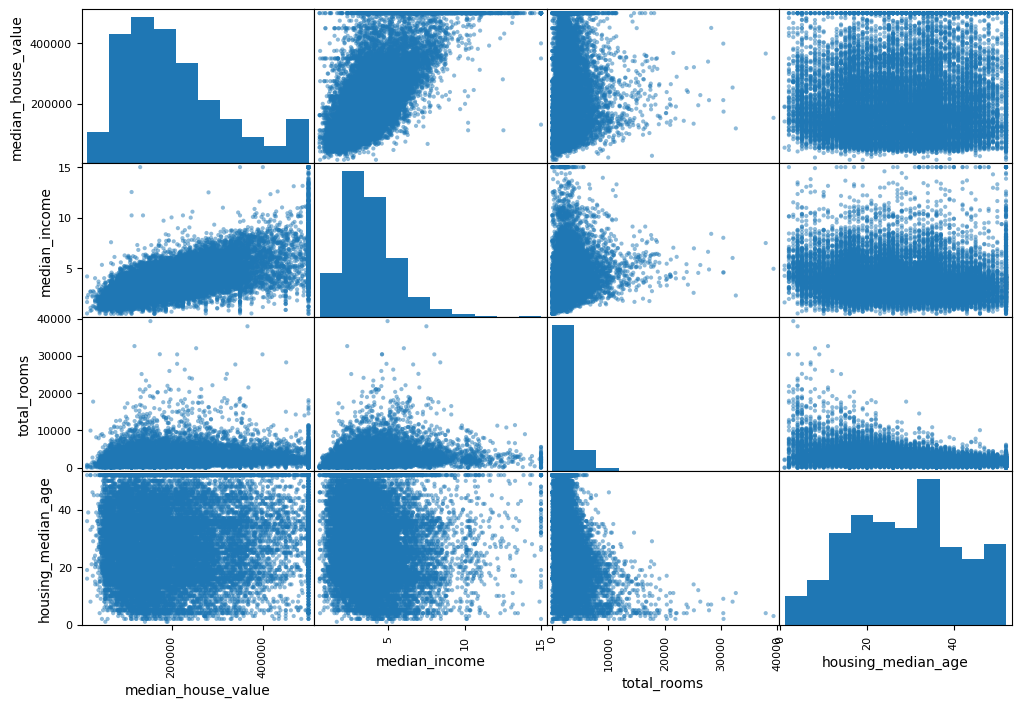

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8));

Again we see how the clearest correlation is with 'median_income', the more it increases, the more the median house value increases. We can also see that the limit of 500,000 USD we mentioned before is clearly visible in the graph, as a horizontal line at the top of the y axis.

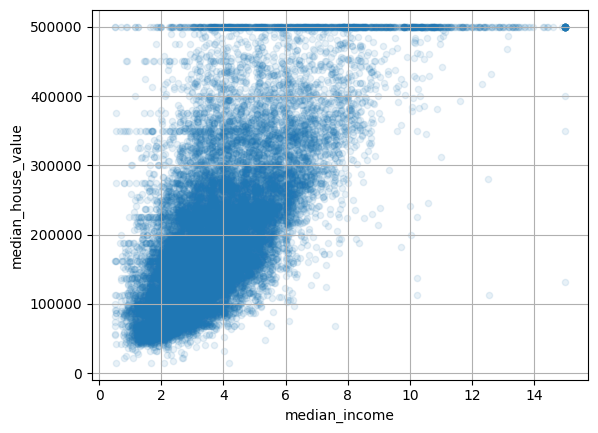

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True);

## Outliers and capped values

As we observed in the [framing notebook](e2e010_framing.ipynb), some variables in this dataset have been **capped**: values exceeding a certain threshold have been replaced with that threshold value. This is evident in the histograms of `housing_median_age` (capped at 52) and `median_house_value` (capped at 500,001 USD), where we see a tall bar at the maximum value.

This is one of several techniques for handling **outliers**—data points that lie far from the bulk of the distribution. Common approaches include:

- **Capping** (or **clipping**): Replacing values beyond a fixed threshold with that threshold. This is what was applied to this dataset. For example, all house values above 500,000 USD were set to 500,001 USD. This preserves the number of observations but loses information about the magnitude of extreme values.

- **Winsorizing**: Similar to capping, but thresholds are defined as percentiles (e.g., the 1st and 99th percentiles) rather than fixed values. This is more statistically principled when the appropriate threshold is unknown.

- **Truncation** (or **trimming**): Removing observations beyond the threshold entirely. Unlike capping, this reduces the sample size.

These techniques matter because outliers can disproportionately affect:
- **Mean imputation**: The mean is sensitive to extreme values, making median imputation preferable when outliers are present (see [missing values notebook](e2e041_missing.ipynb)).
- **Min-Max scaling**: A single extreme value can compress the entire range of "normal" values into a small interval (see [scaling notebook](e2e043_scaling.ipynb)).
- **Model training**: Many algorithms (especially those based on distances or gradients) can be distorted by extreme values.

In this dataset, the capping was applied *before* we received the data. When working with raw data, the decision of whether and how to handle outliers should be made carefully, considering whether extreme values represent errors, rare but valid observations, or genuinely different populations.

The insights gained from EDA—particularly correlations between variables—naturally lead to **feature engineering**: creating new variables that may be more predictive than the raw features. This is covered in the [Feature Engineering notebook](e2e030_feature_engineering.ipynb).